In [4]:
import myServices as ms
import models as md

import os
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score, f1_score
import joblib

In [ ]:
# to compute ececution time do: 
# with timeit():
#     # your code, e.g., 
class timeit(): 
    from datetime import datetime
    def __enter__(self):
        self.tic = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('runtime: {}'.format(self.datetime.now() - self.tic))

## Importing and manipulating datasets

In [ ]:
sklearn.metrics.get_scorer_names()

In [ ]:
### Cleaning basin1DataSet 
dataSetPath = 'datasets/datasetBasin1.csv'
basinDataSet = pd.read_csv(dataSetPath, index_col = None)
# basin1Light = pd.read_csv('datasetBasin1_NoDataFree.csv', index_col = None)
# print(basinDataSet.info())
# basinDataSet.describe()

In [ ]:
basinDataSet.isna().any()

In [ ]:
colNames = ['percentage','DLSOL5R200', 'DLSOL4R150', 'DLSOL5R150']
for col in colNames: 
    basinDataSet[col].fillna(0,inplace=True)

In [ ]:
basinDataSet.dropna(subset=['slope'],inplace=True)

In [ ]:
basinDataSet.drop(['fid'], axis =1, inplace=True)

In [ ]:
basinDataSet.isna().sum()

In [ ]:
#### NOrmalize Flow Accumulation
basinDataSet['FAcc'] = (basinDataSet['FAcc']- basinDataSet['FAcc'].min())/(basinDataSet['FAcc'].max()-basinDataSet['FAcc'].min())


In [ ]:
### Replacing QGIS NoData value(-9999) with 0 
repalcer  = basinDataSet['FAProx_01'].to_numpy()
basinDataSet['FAProx_01'] = [0 if repalcer[j] == -9999 else repalcer[j] for j in range(len(repalcer))]                                                                                                                         
                                                                                                                          

In [ ]:
## Transform a column datatype
repalcer  = basinDataSet['percentage'].to_numpy().astype('int')
basinDataSet.loc[:,'percentage'] = repalcer

In [ ]:
basinDataSet.describe()

In [ ]:
basinDataSet.to_csv('datasets/basin1_FirstFeatureSet_Clean.csv', index=None)

In [ ]:
ds = DS.head(5)
s = {}
s['Datas'] = ds
print(s)

## Proportional Split 

In [ ]:
## Stratified Split
from sklearn.model_selection import StratifiedShuffleSplit

X,Y = ms.importDataSet('datasets/basin1_FirstFeatureSet_Clean.csv', 'percentage')
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
for train_index, test_index in sss.split(X, Y):
    print("TRAIN:", train_index.size, "TEST:", test_index.size)
    X_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = Y.iloc[test_index]

In [ ]:
## Describing training set
print(len(X_train['elevation']), len(y_train) )
trainCount = Counter(y_train)
print(trainCount)

In [ ]:
#####    Creating training set     #####
X_train.loc[:,'percentage'] = y_train
X_train.head()


In [ ]:
## Removing coordinates from training set
X_train.drop(['x_coord','y_coord'], axis =1, inplace=True)
X_train.head()

In [ ]:
X_train.to_csv('datasets/basin1_FirstFeatureSet_Clean_Training.csv', index=None)

In [ ]:
#####. Creating Test set
print(X_test.head())
X_test.loc[:,'percentage'] = y_test
print(X_test.head())
print(X_test.info())
testCount = Counter(X_test['percentage'])
print(f"testCount:  {testCount}")


In [ ]:
X_test.to_csv('datasets/basin1_FirstFeatureSet_Clean_Test.csv', index=None)

In [ ]:
## This proportions are the reason why a sample_weight of 0.01 for the majority class give best results for regression
totalTrain = sum([trainCount[0], trainCount[1], trainCount[5]]) 
totalValidation = sum([testCount[0], testCount[1], testCount[5]])
print(f"total Train samples: {totalTrain},  total Validation samples: {totalValidation}")
print("Summary of traning and test dataset class balance")
print(f"Training Set:", '\n', "Class 0: %.3f" %(trainCount[0]/totalTrain), " Class 1: %.4f" %(trainCount[1]/totalTrain), "Class 5: %.4f"%(trainCount[5]/totalTrain))
print("Testing Set:", '\n', "Class 0: %.3f" %(testCount[0]/totalValidation)," Class 1: %.4f" %(testCount[1]/totalValidation),  "Class 5: %.4f"%(testCount[5]/totalValidation))



In [ ]:
model = ms.loadModel('./outputs/2022-08-05/00-35-58/2208050035.pkl')
dataSetToSave = ms.makePredictionToImportAsSHP(csvName, model, X, Y, 'percentage')
print(dataSetToSave.head())

## Combining dataSets to build AllVsOne_training and OneVsAll_test

In [ ]:
# Concat datasets
sourceFileForDatasets = 'datasets/'
allDataSetsNames = ['basin1Light_Clean.csv', 'basin2_CleanDataSet.csv', 'basin3_CleanDataSet_copy.csv','basin4_CleanDataSet.csv','basin5_CleanDataSet.csv']
# OneVsAllDataSetName = 'basin1Light_Clean.csv'

for datasetForTest in allDataSetsNames:
    filename, file_extension = os.path.splitext(datasetForTest)
    newListOfNames = [s for s in allDataSetsNames if s != datasetForTest]
    allDataSetsFileName = 'allVs_'+ filename +'_Training'
    DFToConcatAll = pd.DataFrame()
#     DFToConcatAll = pd.read_csv((sourceFileForDatasets+datasetForTest), index_col = None)
#     print(DFToConcatAll.head())
    for datasets in newListOfNames:
        DFToConcatAll = pd.concat([DFToConcatAll, pd.read_csv((sourceFileForDatasets+datasets), index_col = None)])
    nameToSafe = sourceFileForDatasets+allDataSetsFileName+file_extension
    DFToConcatAll.drop(['x_coord','y_coord'], axis =1, inplace=True)
    DFToConcatAll.to_csv(nameToSafe, index=None)    
    



## Preparing datasets for MLP

In [ ]:
## Cleaning dataset: Remouving not usefull variables from All_VS_ONE 
readPath = 'datasets/'
destiationPath = 'datasets/dataset4MLP/'
datasetNamelist = ['allVs_basin1Light_Clean_Training.csv', 'allVs_basin2_CleanDataSet_Training.csv','allVs_basin3_CleanDataSet_copy_Training.csv',
'allVs_basin4_CleanDataSet_Training.csv','allVs_basin5_CleanDataSet_Training.csv','basin1Light_Clean_VsAll_Test.csv',
'basin2_CleanDataSet_VsAll_Test.csv','basin3_CleanDataSet_copy_VsAll_Test.csv', 'basin4_CleanDataSet_VsAll_Test.csv', 
'basin5_CleanDataSet_VsAll_Test.csv']
featuresToDelete = ['TPI','TWI']
for i in datasetNamelist:
    path = readPath + i 
    basinDataSet = pd.read_csv(path, index_col = None)
    basinDataSet.drop(featuresToDelete, axis=1, inplace=True)
    savePath = destiationPath + 'MLP_'+i
    basinDataSet.to_csv(savePath, index=None)


In [ ]:
###. Build dataset subset for MLP test (Only first 150K samples)
readPath = 'datasets/dataset4MLP/'
datasetNamelist = ['MLP_allVs_basin1Light_Clean_Training.csv','MLP_basin1Light_Clean_VsAll_Test.csv']
for i in datasetNamelist:
    path = readPath + i 
    basinDataSet = pd.read_csv(path, index_col = None)
    Y = np.array(basinDataSet['percentage'])
    count,_ = md.listClassCountPercent(Y)
    basinDataSet.drop(basinDataSet.loc[150000:count].index,axis=0,inplace=True)
    savePath = readPath + 'reduced_'+i
    basinDataSet.to_csv(savePath, index=None)

In [ ]:
### Exploring datasets
dataset = ['reduced_MLP_allVs_basin1Light_Clean_Training.csv','reduced_MLP_basin1Light_Clean_VsAll_Test.csv']
for i in dataset:
    path = readPath + i 
    print(path)
    basinDataSet = pd.read_csv(path, index_col = None)
    print(basinDataSet.head())
    Y = np.array(basinDataSet['percentage'])
    print(md.listClassCountPercent(Y))

datasets/dataset4MLP/MLP_allVs_basin1Light_Clean_Training.csv
percentage
   DLSOL4R150  DLSOL5R150  DLSOL5R200  FAProx_01  FAProx_025     FAcc  \
0         0.0         0.0         0.0  725.43091   174.75125  0.00000   
1         0.0         0.0         0.0  709.11920   171.02631  0.00000   
2         0.0         0.0         0.0  737.05499   176.23280  0.00001   
3         0.0         0.0         0.0  721.00623   172.53986  0.00000   
4         0.0         0.0         0.0  749.03271   177.79201  0.00000   

   visibility    slope  elevation  
0     0.02455  1.97503  174.32889  
1     0.02849  7.28373  173.66133  
2     0.02651  3.28983  173.39836  
3     0.02117  0.36284  172.95361  
4     0.00134  0.19720  172.93945  
Train balance
(1370466, {0: 'Class_count: 1327657  for  0.9688  percent', 1: 'Class_count: 8130  for  0.0059  percent', 5: 'Class_count: 34679  for  0.0253  percent'})
Iteration 1, loss = 0.16475813
Validation score: 0.969602
Iteration 2, loss = 0.10352420
Validation scor

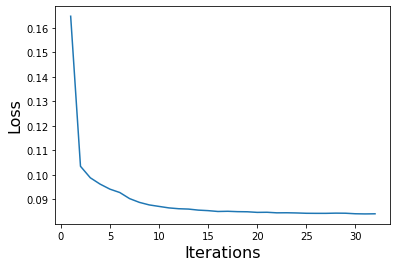

In [5]:
####.  Training TEST

readPath = 'datasets/dataset4MLP/'
trainingPath = readPath + 'MLP_allVs_basin1Light_Clean_Training.csv'
# dataset = pd.read_csv(trainingPath, index_col = None)
args = {'eStop': True, 'verbose': 10}
mlpc = md.implementingMLPCalssifier(trainingPath,'percentage',args)
mlpc.fitMLPClassifier()
mlpc.plotLossBehaviour()

mlpClassifier = mlpc.getMLPClassifier()

In [10]:
#Validating un unseen dataset
validation = readPath + 'MLP_basin1Light_Clean_VsAll_Test.csv'
x_val,y_val = ms.importDataSet(validation, 'percentage')
print(x_val.head())
prediction = ms.makePredictionToImportAsSHP(mlpClassifier, x_val, y_val, 'percentage')


   DLSOL4R150  DLSOL5R150  DLSOL5R200  FAProx_01  FAProx_025      FAcc  \
0         0.0         0.0         0.0   84.64632   423.23163  0.000006   
1         0.0         0.0         0.0   84.50444   422.52222  0.000005   
2         0.0         0.0         0.0   83.86894   419.34473  0.000006   
3         0.0         0.0         0.0   83.24062   416.20306  0.000006   
4         0.0         0.0         0.0   84.38602   421.93008  0.000004   

   visibility     slope  elevation  x_coord  y_coord  
0     0.01819   8.52348   48.30993   370378  5267893  
1     0.01684  10.78189   48.82024   370373  5267888  
2     0.01800   8.48582   48.04361   370378  5267888  
3     0.02040   8.44216   47.46280   370383  5267888  
4     0.01633  14.52239   49.66032   370368  5267883  


/Users/abdielfer/DESS/Internship2022/RNCanWork/FloodProbabRNCanAbd/venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [8]:
prediction.head()

,DLSOL4R150,DLSOL5R150,DLSOL5R200,FAProx_01,FAProx_025,FAcc,visibility,slope,elevation,percentage,x_coord,y_coord,prediction
0,0.0,0.0,0.0,84.64632,423.23163,0.000006,0.01819,8.52348,48.30993,0,370378,5267893,0
1,0.0,0.0,0.0,84.50444,422.52222,0.000005,0.01684,10.78189,48.82024,0,370373,5267888,0
2,0.0,0.0,0.0,83.86894,419.34473,0.000006,0.01800,8.48582,48.04361,0,370378,5267888,0
3,0.0,0.0,0.0,83.24062,416.20306,0.000006,0.02040,8.44216,47.46280,0,370383,5267888,0
4,0.0,0.0,0.0,84.38602,421.93008,0.000004,0.01633,14.52239,49.66032,0,370368,5267883,0


In [12]:
prediction.to_csv((readPath + 'MLP_basin1Light_firstResult.csv'),index=None)

In [17]:
X = x_val.copy()
X.drop(['percentage','x_coord','y_coord','prediction'], axis=1, inplace=True)
md.computeClassificationMetrics(mlpClassifier,X,y_val)

/Users/abdielfer/DESS/Internship2022/RNCanWork/FloodProbabRNCanAbd/venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


UNIQUE CLASSES:  [0 1 5]
Accuraci_score:  0.968103349719904
F1_macroAverage:  0.4499682795129307
F1_microAverage:  0.968103349719904
ROC_AUC one_vs_all:  {0: 0.6795384703407465, 1: 0.5, 5: 0.6929367088067127}


(0.968103349719904,
 0.4499682795129307,
 0.968103349719904,
 {0: 0.6795384703407465, 1: 0.5, 5: 0.6929367088067127})

## Controled sampling

In [ ]:
DS = pd.read_csv('datasets/basin2 _Training.csv', index_col = None)
print(DS.head())


In [ ]:
print(DS.columns)

In [ ]:
plt.boxplot(DS['FAProx_01']) # , , DS['elevation'], DS['disToRiv']]

In [ ]:
## Resampling appliying class selection by rule:

# RULE1: Select point at a distance to river less than 300m. 

# # newDS = pseudoClassCreation(DS, "distanceToRiver", 300, 2)
def pseudoClassCreation(dataset, conditionVariable, threshold, pseudoClass, targetClassName):
    '''
    Replace <targetClass> by  <pseudoClass> where <conditionVariable >= threshold>. 
    Return:
      dataset with new classes group. 
    '''
    datsetReclassified = dataset.copy()
    actualTarget = (np.array(dataset[targetClassName])).ravel()
    conditionVar = (np.array(dataset[conditionVariable])).ravel()
    datsetReclassified[targetClassName] = [ pseudoClass if conditionVar[j] >= threshold 
                                           else actualTarget[j]
                                           for j in range(len(actualTarget))]
    print(Counter(datsetReclassified[targetClassName]))
    return  datsetReclassified

def revertPseudoClassCreation(dataset, originalClass, pseudoClass, targetClassName):
    '''
    Restablich  <targetClass> with <originalClass> where <targetClassName == pseudoClass>. 
    Return:
      dataset with original classes group. 
    '''
    datsetReclassified = dataset.copy()
    actualTarget = (np.array(dataset[targetClassName])).ravel()
    datsetReclassified[targetClassName] = [ originalClass if actualTarget[j] == pseudoClass
                                           else actualTarget[j]
                                           for j in range(len(actualTarget))]
    print(Counter(datsetReclassified[targetClassName]))
    return  datsetReclassified


print(Counter(X_train['percentage']))
newDS = pseudoClassCreation(X_train, 'disToRiv', 200, 2, 'percentage')
y = newDS['percentage']
newDS.drop(['percentage'], axis=1, inplace = True)
x_res,y_res = ms.randomUndersampling(newDS, y, )
x_res['percentage'] = y_res
# newDatase = revertPseudoClassCreation(x_res, 0, 2, 'percentage')


In [ ]:
x_res.to_csv('basin1ControlClass0Sampling4Class_ToSHP.csv',index = None)

# Data description and visualization

In [ ]:
#### import dataset to describe
DS= pd.read_csv('datasets/basin4_Training.csv', index_col=None)
DS.head()

In [ ]:
DS.drop(['x_coord','y_coord'], axis = 1, inplace=True)
DS.head()

In [ ]:
### FAcc vs Labels
targets = DS['percentage']
FAcc = original['FAcc']
FAcc_norm = DS['FAcc_norm']
fig, axs = plt.subplots(1, 2, figsize=(13,4), sharey=True)
fig.text(-0.02, 0.5, 'labels', va='center', rotation='vertical')
fig.text(0.5, 1, 'Flow accumulation vs labels distribution', ha ='center')
axs[0].scatter(FAcc,targets)
# axs[0].set_title("Facc")
axs[0].set(xlabel='a) Flow Accumulation')
axs[1].scatter(FAcc_norm,targets)
# axs[1].set_title("FAcc_norm")
axs[1].set(xlabel='b) Flow Accumulation estandardized')
plt.rcParams['font.size'] = '20'
fig.tight_layout()


In [ ]:

## Plot all features vs labels
# 'disToRiv', 'TWI', 'TPI', 'slope', 'elevation',

targets = DS['percentage']
# targets = np.where(targets == 5,2,targets)

E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc']
TWI = DS['TWI']
TPI = DS['TPI']
DLSOL4R150 = DS['LDSOL4R150']
DLSOL5R150 = DS['LDSOL5R150']
DLSOL5R200 = DS['LDSOL5R200']
FAProx_01 = DS['FAProx_01']
FAProx_025 = DS['FAProx_025']
visibility = DS['visibility']

fig, axs = plt.subplots(4,3, figsize=(13, 8), sharey=True)
fig.supylabel('Labels')
plt.rcParams['font.size'] = '15'
plt.yticks([0,1,5])

'''
E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc']
TWI = DS['TWI']
'''
axs[0, 0].scatter(E,targets)
axs[0, 0].set_title("Elevation")
axs[1, 0].scatter(slope,targets)
axs[1, 0].set_title("Slope")
axs[2, 0].scatter(FAcc,targets)
axs[2, 0].set_title("Flow accumulation")
axs[3, 0].scatter(TWI,targets)
axs[3, 0].set_title("TWI")

'''
TPI = DS['TPI']
DLSOL4R150 = DS['DLSOL4R150']
DLSOL5R150 = DS['DLSOL5R150']
DLSOL5R200 = DS['DLSOL5R200']
'''
axs[0, 1].scatter(TPI,targets)
axs[0, 1].set_title('TPI')
axs[1, 1].scatter(DLSOL4R150,targets)
axs[1, 1].set_title("DLSOL4R150")
axs[2, 1].scatter(DLSOL5R150,targets)
axs[2, 1].set_title("DLSOL5R150")
axs[3, 1].scatter(DLSOL5R200,targets)
axs[3, 1].set_title("DLSOL5R200")

'''
FAProx_01 = DS['FAProx_01']
FAProx_025 = DS['FAProx_025']
visibility = DS['visibility']
'''
axs[0, 2].scatter(FAProx_01,targets)
axs[0, 2].set_title('FAProx_01')
axs[1, 2].scatter(FAProx_025,targets)
axs[1, 2].set_title("FAProx_025")
axs[2, 2].scatter(visibility,targets)
axs[2, 2].set_title("Visibility")

fig.tight_layout()


In [ ]:
print(DS.head())
#  Return a dataset with the rows corresponding to the index where condition in DS.columName is valid. 
dsArray = DS[DS.percentage != 0] 
print(dsArray.head()) 

In [ ]:
sns.set(font_scale=1.5)
sns.pairplot(DS, hue = 'percentage', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.8, 's': 100},
             height = 4, corner=True, palette = "Set2")# vars = ['life_exp', 'log_pop', 'log_gdp_per_cap'],

# sns.pairplot(DS, hue="percentage")

In [ ]:
####. Covariance Matrix
sns.set(font_scale=0.7)
matrix = DS.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.set_figsize=(25,20)
plt.show()

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(criterion='entropy', random_state = 50)
x_train,y_train = ms.importDataSet('basin1Train.csv', 'percentage')
classifier = OneVsRestClassifier(estimator).fit(x_train,y_train)


In [ ]:
classifier = ms.loadModel('./outputs/2022-08-05/11-01-57/2208051101.pkl')
x_test,y_test = ms.importDataSet('basin1Test.csv', 'percentage')

x_test = ms.removeCoordinatesFromDataSet(x_test)

# y_prob = classifier.predict_proba(x_test)
#print(np.unique(y_prob))

In [ ]:
md.plot_ROC_AUC_OneVsRest(classifier, x_test, y_test)

In [ ]:
_,y_test = ms.importDataSet('./bestModels/Classifier/10-18-08/2208051018prediction_basin1Test.csv', 'prediction')
unique, count = np.unique(y_test, return_counts=True)
total = count.sum()
print(total)
percent = np.round(np.zeros_like(unique).astype('float16'),3)
print('values, counts , percent')
for i in range(len(unique)):    
   percent[i] = (count[i]/total)*100
   print(unique[i],"\t", count[i], percent[i])
